# Libraries

In [1]:
import sys
import os
import re
sys.path.append('../src')
sys.path.append('modules')
import heapq
from PIL import Image
from lib_model import Str_Model
from lib_utils import Dec2Dna
from Bio import SeqIO
from Bio.Align.Applications import MuscleCommandline
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from collections import defaultdict, Counter
from itertools import combinations
import struct
import zlib
import matplotlib.pyplot as plt
import subprocess
import tempfile
import numpy as np

/home/tulyau/.local/lib/python3.11/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


# Fonctions

## Utilitaires - Tests et traitement des résulats

In [2]:
def insert_nucleotide_in_homopolymers(Xdna, min_length=4):
    """
    Insère un nucléotide au milieu des homopolymères de longueur supérieure ou égale à min_length.

    Args:
        Xdna (str): La séquence d'ADN dans laquelle insérer les nucléotides.
        min_length (int): La longueur minimale des homopolymères pour l'insertion.
        
    Returns:
        str: La séquence d'ADN modifiée avec les nucléotides insérés.
    """
    # Fonction pour insérer un nucléotide au milieu d'un homopolymère
    def insert_nucleotide(match):
        seq = match.group(0)
        mid = len(seq) // 2  # Trouver le milieu
        if seq[0] == 'T':
            insertion = 'A'
        elif seq[0] == 'A':
            insertion = 'T'
        elif seq[0] == 'C':
            insertion = 'G'
        else:
            insertion = 'C'
        # Insérer le nucléotide au milieu de la séquence
        return seq[:mid] + insertion + seq[mid:]  # Insérer le nucléotide au milieu
    
    # Répéter jusqu'à ce qu'il n'y ait plus d'homopolymères
    last_sequence = []
    modified_sequence = Xdna
    while modified_sequence != last_sequence:
        last_sequence = modified_sequence
        # Utiliser une expression régulière pour trouver les homopolymères
        pattern = r"([ATGC])\1{" + str(min_length - 1) + r",}"
        modified_sequence = re.sub(pattern, insert_nucleotide, modified_sequence)
    
    
    return modified_sequence

In [3]:
def binaryToDna(codeword):
    """
    Convert a binary sequence to a DNA sequence with improved robustness.
    
    Args:
        codeword (array-like): Binary sequence (0s and 1s)
    
    Returns:
        list: DNA sequence as a list of characters (A, C, G, T)
    """
    # Handle empty input
    if len(codeword) == 0:
        return []
    
    # Ensure codeword is a numpy array for consistency
    if not isinstance(codeword, np.ndarray):
        codeword = np.array(codeword)
    
    # Make sure the length is even by padding with a 0 if necessary
    if len(codeword) % 2 != 0:
        codeword = np.append(codeword, 0)
    
    # Group binary digits in pairs and convert to base-4 values
    base4_values = []
    for i in range(0, len(codeword), 2):
        # Ensure we don't go out of bounds
        if i+1 < len(codeword):
            pair = (codeword[i], codeword[i+1])
            if pair == (0, 0):
                base4_values.append(0)  # A
            elif pair == (0, 1):
                base4_values.append(1)  # C
            elif pair == (1, 0):
                base4_values.append(2)  # G
            elif pair == (1, 1):
                base4_values.append(3)  # T
        else:
            # Handle odd length by adding a default value
            base4_values.append(0)  # A
    
    # Convert base-4 values to DNA sequence using imported Dec2Dna
    try:
        return Dec2Dna(base4_values)
    except Exception as e:
        # Fallback conversion in case the imported function fails
        print(f"Warning: Error in Dec2Dna, using fallback conversion: {e}")
        dna_map = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
        return [dna_map[val] for val in base4_values]

In [4]:
def DnaToBinary(dna_sequence):
    """
    Convert a DNA sequence to a binary sequence with improved robustness.
    
    Args:
        dna_sequence (str or list): DNA sequence (A, C, G, T)
    
    Returns:
        numpy.ndarray: Binary sequence (0s and 1s)
    """
    # Handle empty input
    if not dna_sequence:
        return np.array([], dtype=np.int8)

    # Create a mapping from DNA bases to binary pairs
    base_to_binary = {
        'A': (0, 0), 
        'C': (0, 1), 
        'G': (1, 0), 
        'T': (1, 1), 
        '-': (0, 0),  # Handle gaps by mapping to A
        'N': (0, 0)   # Handle unknown bases by mapping to A
    }
    
    # Convert each base in the DNA sequence to its corresponding binary pair
    binary_sequence = []
    for base in dna_sequence:
        # Convert to uppercase and handle unknown bases
        base = base.upper() if isinstance(base, str) else base
        if base in base_to_binary:
            binary_sequence.extend(base_to_binary[base])
        else:
            # For any unrecognized character, use the default mapping (A)
            binary_sequence.extend(base_to_binary['A'])
    
    return np.array(binary_sequence, dtype=np.int8)

In [5]:
def Dna2B4(seq):
    """
    Convert a DNA sequence to base 4 values.
    
    Args:
        seq (str or list): DNA sequence containing A, C, G, T
    
    Returns:
        list: List of base 4 values (0, 1, 2, 3)
    """
    base4_values = []
    for base in seq:
        if base == 'A':
            base4_values.append(0)
        elif base == 'C':
            base4_values.append(1)
        elif base == 'G':
            base4_values.append(2)
        elif base == 'T':
            base4_values.append(3)
    
    return base4_values

In [6]:
def levenshtein(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((     
        size_x,
        size_y
    ))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    return (matrix[size_x - 1, size_y - 1])

In [7]:
def calculate_accuracy(corrected_sequence, Xdna):
    if len(corrected_sequence) == len(Xdna):
        # Calculate accuracy as the number of matching bases divided by the length of the sequence
        accuracy = sum([corrected_sequence[i] == Xdna[i] for i in range(len(corrected_sequence))])
        return accuracy / len(corrected_sequence)
    correct = 0
    for i in range(len(corrected_sequence) - len(Xdna)):
        accuracy = sum([corrected_sequence[i+j] == Xdna[j] for j in range(len(Xdna))])
        correct = max(correct, accuracy)
    return correct / len(corrected_sequence)

## Utilitaires - Image

In [101]:
def imageToBinary(image_):
    img=open(image_, 'rb') #read
    binaire=img.read()
    img.close()
    binarychain=""
    for byte in binaire:
        binarychain+=format(byte,'08b') #passe les octets en binaire 
    outputimg=os.path.splitext(image_)[0] + "binary_.txt"    #creer le fichier text ou on va enregistrer l'image en binaire 
    output_file=open(outputimg,'w')
    output_file.write(binarychain)
    output_file.close()

In [127]:
def binaryToImage(binary_file, output_filename):
    # Lire le fichier binaire contenant les données d'image
    with open(binary_file, 'r') as file:
        binary_data = file.read()
    
    # Convertir la chaîne binaire en octets
    image_bytes = bytearray(int(binary_data[i:i+8], 2) for i in range(0, len(binary_data), 8))
    
    # Sauvegarder les octets sous forme d'image
    with open(output_filename, 'wb') as img_file:
        img_file.write(image_bytes)

In [ ]:
# Fix the huffmanCompression function to handle binary files correctly
def huffmanCompression(input_file, output_file=None):
    if output_file is None:
        output_file = os.path.splitext(input_file)[0] + ".huff"
    
    # Read the input file in binary mode
    with open(input_file, 'rb') as file:
        data = file.read()
    
    # Convert bytes to a list of integers for processing
    binary_data = list(data)
    
    # Calculate frequency of each byte
    freq = Counter(binary_data)
    
    # Create a priority queue with nodes (frequency, index, byte value)
    heap = [[weight, i, byte] for i, (byte, weight) in enumerate(freq.items())]
    heapq.heapify(heap)
    
    # Build Huffman tree
    count = len(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        heapq.heappush(heap, [lo[0] + hi[0], count, [lo, hi]])
        count += 1
    
    # Generate Huffman codes
    codes = {}
    
    def traverse_tree(node, code=''):
        if len(node) == 3 and not isinstance(node[2], list):
            codes[node[2]] = code
            return
        traverse_tree(node[2][0], code + '0')
        traverse_tree(node[2][1], code + '1')
    
    traverse_tree(heap[0])
    
    # Encode the data
    encoded_text = ''.join(codes[byte] for byte in binary_data)
    
    # Prepare header with frequency data
    header = str(len(freq)) + '\n'
    for byte, frequency in freq.items():
        header += f"{byte} {frequency}\n"
    
    # Calculate padding
    padding = 8 - (len(encoded_text) % 8) if len(encoded_text) % 8 != 0 else 0
    header += f"{padding}\n"
    
    # Convert binary string to bytes
    padded_text = encoded_text + '0' * padding
    bytes_array = bytearray(int(padded_text[i:i+8], 2) for i in range(0, len(padded_text), 8))
    
    # Write to output file
    with open(output_file, 'wb') as file:
        file.write(header.encode())
        file.write(bytes_array)
    
    return output_file

In [193]:
def huffmanDecompression(input_file, output_file=None):
    """
    Decompress a file compressed with Huffman coding.
    
    Args:
        input_file (str): Path to the compressed file
        output_file (str, optional): Path to the output decompressed file
    
    Returns:
        str: Path to the decompressed file
    """
    if output_file is None:
        output_file = os.path.splitext(input_file)[0] + "_decompressed.txt"
    
    # Read the compressed file
    with open(input_file, 'rb') as file:
        # Parse header
        try :
            num_chars = int(file.readline().decode().strip())
        except ValueError:
            num_chars = 2 # Default to 2 if parsing fails
        
        # Rebuild frequency dictionary
        freq = {}
        for _ in range(num_chars):
            try :
                line = file.readline().decode().strip().split()
            except UnicodeDecodeError:
                # Handle potential decoding errors
                raw_line = file.readline()
                try:
                    line = raw_line.decode('utf-8').strip().split()
                except UnicodeDecodeError:
                    # Use latin1 which can decode any byte value (0-255)
                    line = raw_line.decode('latin1').strip().split()
            char_code = int(line[0])
            frequency = int(line[1])
            freq[chr(char_code)] = frequency
        
        padding = int(file.readline().decode().strip())
        
        # Read the compressed data
        compressed_data = file.read()
    
    # Convert bytes to binary string
    binary_string = ''.join(format(byte, '08b') for byte in compressed_data)
    
    # Remove padding
    if padding > 0:
        binary_string = binary_string[:-padding]
    
    heap = [[weight, i, char] for i, (char, weight) in enumerate(freq.items())]
    heapq.heapify(heap)
    
    count = len(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        heapq.heappush(heap, [lo[0] + hi[0], count, [lo, hi]])
        count += 1
    
    # Decode the compressed data
    decoded_text = ""
    current_code = ""
    root = heap[0]
    
    for bit in binary_string:
        current_code += bit
        current_node = root
        
        # Traverse the tree according to the code
        for bit_in_code in current_code:
            if bit_in_code == '0':
                current_node = current_node[2][0]
            else:
                current_node = current_node[2][1]
                
            # If we reach a leaf node
            if len(current_node) == 3 and isinstance(current_node[2], str):
                decoded_text += current_node[2]
                current_code = ""
                break
    
    # Write decompressed data to file
    with open(output_file, 'w') as file:
        file.write(decoded_text)
    
    return output_file

In [105]:
def huffman_to_dna(huffman_file):
    """
    Convert a Huffman compressed file into a DNA sequence.
    
    Args:
        huffman_file (str): Path to the Huffman compressed file
    
    Returns:
        str: DNA sequence representing the file
    """
    # Read the Huffman file as binary
    with open(huffman_file, 'rb') as file:
        binary_data = file.read()
    
    # Convert binary data to a string of 0s and 1s
    binary_string = ''.join(format(byte, '08b') for byte in binary_data)
    
    # Make sure the length is a multiple of 2 (needed for base-4 conversion)
    if len(binary_string) % 2 != 0:
        binary_string += '0'
    
    # Convert binary string to base-4 values
    base4_values = []
    for i in range(0, len(binary_string), 2):
        pair = binary_string[i:i+2]
        if pair == '00':
            base4_values.append(0)
        elif pair == '01':
            base4_values.append(1)
        elif pair == '10':
            base4_values.append(2)
        elif pair == '11':
            base4_values.append(3)
    
    # Convert base-4 values to DNA sequence
    dna_sequence = Dec2Dna(base4_values)
    
    return dna_sequence

In [124]:
def dna_to_huffman(dna_sequence, output_file):
    """
    Convert a DNA sequence back to a Huffman compressed file.
    
    Args:
        dna_sequence (str): DNA sequence to convert
        output_file (str): Path to save the Huffman file
    
    Returns:
        str: Path to the created Huffman file
    """
    # Convert DNA to base-4 values
    base4_values = Dna2B4(dna_sequence)
    
    # Convert base-4 values to binary string
    binary_string = ''
    for value in base4_values:
        if value == 0:
            binary_string += '00'
        elif value == 1:
            binary_string += '01'
        elif value == 2:
            binary_string += '10'
        elif value == 3:
            binary_string += '11'
    
    # Convert binary string to bytes
    # Make sure the length is a multiple of 8
    padding = (8 - (len(binary_string) % 8)) % 8
    binary_string += '0' * padding
    
    # Convert groups of 8 bits to bytes
    bytes_array = bytearray(int(binary_string[i:i+8], 2) for i in range(0, len(binary_string), 8))
    
    # Write to output file
    with open(output_file, 'wb') as file:
        file.write(bytes_array)
    
    return output_file

In [107]:
def imageToDna (image_file):
    """
    Convert an image file to a DNA sequence.
    
    Args:
        image_file (str): Path to the image file
    
    Returns:
        str: DNA sequence representing the image
    """
    # Convert image to binary
    binary_file = os.path.splitext(image_file)[0] + "binary_.txt"
    imageToBinary(image_file)
    
    # Compress the binary file using Huffman coding
    huffman_file = huffmanCompression(binary_file)
    
    # Convert the Huffman compressed file to DNA
    dna_sequence = huffman_to_dna(huffman_file)

    # Clean up temporary files
    os.remove(binary_file)
    os.remove(huffman_file)

    return dna_sequence

In [ ]:
def dnaToImage (dna_sequence, output_image):
    """
    Convert a DNA sequence back to an image file.
    
    Args:
        dna_sequence (str): DNA sequence to convert
        output_image (str): Path to save the output image file
    
    Returns:
        str: Path to the created image file
    """
    # Convert DNA sequence back to Huffman compressed binary
    huffman_file = os.path.splitext(output_image)[0] + ".huff"
    dna_to_huffman(dna_sequence, huffman_file)
    
    # Decompress the Huffman file to binary
    binary_file = os.path.splitext(output_image)[0] + "_decompressed.txt"
    huffmanDecompression(huffman_file, binary_file)
    
    # Convert binary back to image
    binaryToImage(binary_file, output_image)

    # Clean up temporary files
    os.remove(huffman_file)
    os.remove(binary_file)

    return output_image

## Utilitaires - Alignement et modèle

In [16]:
def use_model(Xdna, Nb_reads):
    try :
        reads = model.channel_simulator(Xdna,Nb_reads)   
    except:
        reads = use_model(Xdna,Nb_reads)
    return reads

In [17]:
def to_fasta(reads, filename):
    f = open(filename, "w")
    for i in range(len(reads)):
        f.write(">read" + str(i) + "\n")
        f.write(''.join(reads[i]) + "\n")
    f.close()

In [18]:
def align_sequences(input_file, max_retries=3):
    """
    Align sequences using MUSCLE with improved error handling and retry mechanism.
    
    Args:
        input_file (str): Path to the FASTA file containing sequences to align
        max_retries (int): Maximum number of retries if alignment fails
    
    Returns:
        list: List of aligned sequence records
    """
    sequences = list(SeqIO.parse(input_file, "fasta"))
    
    # Check if we have sequences to align
    if not sequences:
        print("Warning: No sequences found to align")
        return []
    
    # If there's only one sequence, no need to align
    if len(sequences) == 1:
        return sequences
        
    # Check if sequences are too large, split if necessary
    max_seq_length = max(len(seq.seq) for seq in sequences)
    if max_seq_length > 10000:
        print(f"Sequences are very long ({max_seq_length} bases), using chunked alignment")
        return aligned_large_sequences(input_file)
    
    # Write sequences to a temporary input file
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as input_temp:  
        SeqIO.write(sequences, input_temp.name, "fasta")
    
    # Create a temporary output file for aligned sequences
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as output_temp:
        output_file = output_temp.name
    
    # Try alignment with retries
    for attempt in range(max_retries):
        try:
            # Run MUSCLE alignment with reasonable timeout
            muscle_cline = f"muscle -align {input_temp.name} -output {output_file}"
            
            # Use subprocess with timeout to prevent hanging
            process = subprocess.run(
                muscle_cline, 
                shell=True, 
                check=True, 
                stderr=subprocess.PIPE,
                timeout=300  # 5 minute timeout
            )
            
            # If successful, read the aligned sequences
            aligned_sequences = list(SeqIO.parse(output_file, "fasta"))
            
            # Check if alignment was successful
            if aligned_sequences and len(aligned_sequences) == len(sequences):
                # Clean up temporary files
                os.remove(input_temp.name)
                
                # Return aligned sequences
                return aligned_sequences
            else:
                print(f"Alignment produced incomplete results, retrying ({attempt+1}/{max_retries})")
        
        except subprocess.TimeoutExpired:
            print(f"Alignment timed out, retrying with different parameters ({attempt+1}/{max_retries})")
            # For timeout, try with faster alignment options
            muscle_cline = f"muscle -align {input_temp.name} -output {output_file} -maxiters 2 -diags"
        
        except subprocess.CalledProcessError as e:
            print(f"MUSCLE alignment failed ({attempt+1}/{max_retries}): {e.stderr.decode()}")
            # Try with different parameters on failure
            if attempt < max_retries - 1:
                # Try with more conservative parameters
                muscle_cline = f"muscle -align {input_temp.name} -output {output_file} -maxiters 2"
    
    # If all attempts failed, try a fallback method
    print("All alignment attempts failed, using fallback alignment method")
    
    # Fallback: Simple star alignment around the longest sequence
    longest_seq = max(sequences, key=lambda seq: len(seq.seq))
    
    # Use the longest sequence as the reference
    for seq in sequences:
        if seq.id != longest_seq.id:
            # Pad shorter sequences with gaps
            gap_count = len(longest_seq.seq) - len(seq.seq)
            if gap_count > 0:
                seq.seq = seq.seq + '-' * gap_count
    
    # Clean up temporary files
    os.remove(input_temp.name)
    if os.path.exists(output_file):
        os.remove(output_file)
    
    return sequences

In [19]:
def aligned_large_sequences(input_file):
    """
    Divide large sequences into smaller chunks, align each chunk separately,
    and concatenate the results to get fully aligned sequences.
    """
    # Read the input file
    aligned_sequences = list(SeqIO.parse(input_file, "fasta"))

    # Check if there are any sequences to align
    if not aligned_sequences:
        return []

    # Number of chunks
    num_chunks = 1000

    # Extract sequences as strings
    sequences = [str(record.seq) for record in aligned_sequences]

    # Find max sequence length
    max_length = max(len(seq) for seq in sequences)

    # Calculate chunk size
    chunk_size = max(1, (max_length + num_chunks - 1) // num_chunks)

    # Create chunks for each sequence
    sequence_chunks = []
    for seq in sequences:
        chunks = []
        for i in range(0, max_length, chunk_size):
            # Extract chunk or use empty string if beyond sequence length
            chunk = seq[i:i+chunk_size] if i < len(seq) else ""
            chunks.append(chunk)
        sequence_chunks.append(chunks)

    # Align corresponding chunks
    aligned_chunks = []
    for i in range(min(num_chunks, len(sequence_chunks[0]))):
        # Get the i-th chunk from each sequence
        chunk_group = [seq_chunks[i] if i < len(seq_chunks) else "" for seq_chunks in sequence_chunks]
        
        # Skip if all chunks are empty
        if all(not chunk for chunk in chunk_group):
            continue
        
        # Create temporary FASTA file for this chunk group
        with tempfile.NamedTemporaryFile(mode='w', delete=False) as temp_file:
            for j, chunk in enumerate(chunk_group):
                temp_file.write(f">seq{j}_chunk{i}\n{chunk}\n")
            temp_filename = temp_file.name
        
        try:
            # Align chunks using the provided align_sequences function
            aligned_chunk_records = align_sequences(temp_filename)
            
            # Extract aligned sequences
            aligned_chunk_seqs = [str(record.seq) for record in aligned_chunk_records]
            aligned_chunks.append(aligned_chunk_seqs)
        except Exception as e:
            print(f"Error aligning chunk {i}: {e}")
            # If alignment fails, use original chunks with padding
            max_chunk_len = max(len(chunk) for chunk in chunk_group) if chunk_group else 0
            padded_chunks = [chunk.ljust(max_chunk_len, '-') for chunk in chunk_group]
            aligned_chunks.append(padded_chunks)
        finally:
            # Clean up
            if os.path.exists(temp_filename):
                os.remove(temp_filename)

    # Concatenate aligned chunks for each sequence
    aligned_sequences_str = [""] * len(sequences)
    for i in range(len(sequences)):
        for chunk_group in aligned_chunks:
            if i < len(chunk_group):
                aligned_sequences_str[i] += chunk_group[i]

    # Create new sequence records with aligned sequences

    result = []
    for i, aligned_seq in enumerate(aligned_sequences_str):
        if i < len(aligned_sequences):
            original_record = aligned_sequences[i]
            new_record = SeqRecord(
                Seq(aligned_seq),
                id=original_record.id,
                name=original_record.name,
                description=original_record.description
            )
            result.append(new_record)

    return result

In [20]:
def build_consensus(aligned_sequences):
    """Build consensus sequence from aligned sequences with improved handling of gaps and ambiguities.
    
    Args:
        aligned_sequences (list): List of SeqRecord objects with aligned sequences
        
    Returns:
        str: Consensus sequence built from the aligned sequences
    """
    if not aligned_sequences:
        return ""
    
    seq_length = len(aligned_sequences[0].seq)
    consensus = []
    
    for i in range(seq_length):
        # Count occurrences of each nucleotide at this position
        counts = defaultdict(int)
        
        # Only count valid nucleotides (ignore gaps for counting)
        valid_nucleotides = 0
        
        for record in aligned_sequences:
            if i < len(record.seq):  # Ensure we don't go out of bounds
                nucleotide = record.seq[i].upper()
                if nucleotide in 'ATGC':  # Only count valid nucleotides
                    counts[nucleotide] += 1
                    valid_nucleotides += 1
        
        # Skip positions where there are no valid nucleotides
        if valid_nucleotides == 0:
            continue
            
        # If most positions are gaps, consider skipping
        gap_count = sum(1 for record in aligned_sequences if i < len(record.seq) and record.seq[i] == '-')
        if gap_count > len(aligned_sequences) / 2:
            # Skip this position if it's mostly gaps
            continue
            
        # If we have valid nucleotides, find the most common one
        if counts:
            # Find the nucleotide with the highest count
            max_count = max(counts.values())
            candidates = [nuc for nuc, cnt in counts.items() if cnt == max_count]
            
            # Sort candidates alphabetically to break ties consistently
            candidates.sort()
            
            # Add the consensus nucleotide
            consensus.append(candidates[0])
    
    return ''.join(consensus)

# LDPC

## Class LDPC

In [21]:
class LDPC:
    def __init__(self, k=205, rate=0.5):
        """
        Initialize an LDPC code with message length k and code rate.
        
        Args:
            k (int): Message length (default: 205)
            rate (float): Code rate (default: 0.5)
        """
        self.k = k  # Message length
        self.rate = rate
        self.n = int(k / rate)  # Codeword length
        self.m = self.n - self.k  # Number of parity bits
        
        # Generate parity-check matrix
        self.H = self._generate_parity_check_matrix()
        
        # Generate generator matrix
        self.G = self._generate_generator_matrix()
    
    def _generate_parity_check_matrix(self):
        """
        Generate a sparse parity-check matrix H with size m x n.
        """
        # Set parameters for parity-check matrix
        row_weight = 6  # Number of 1s per row
        col_weight = 3  # Number of 1s per column
        
        # Initialize an empty parity-check matrix
        H = np.zeros((self.m, self.n), dtype=np.int8)
        
        # Populate each row with a specific number of 1s
        for i in range(self.m):
            # Select random columns for placing 1s
            cols = np.random.choice(self.n, row_weight, replace=False)
            H[i, cols] = 1
        
        # Ensure each column has the right weight
        for j in range(self.n):
            weight = np.sum(H[:, j])
            if weight > col_weight:
                # Remove excess 1s
                ones = np.where(H[:, j] == 1)[0]
                to_remove = np.random.choice(ones, weight - col_weight, replace=False)
                H[to_remove, j] = 0
            elif weight < col_weight:
                # Add missing 1s
                zeros = np.where(H[:, j] == 0)[0]
                to_add = np.random.choice(zeros, col_weight - weight, replace=False)
                H[to_add, j] = 1
        
        return H
    
    def _generate_generator_matrix(self):
        """
        Generate a generator matrix G from parity-check matrix H.
        Converts H to systematic form [P | I] and returns G = [I | P^T].
        """
        # Make a copy of H to avoid modifying the original
        H_copy = self.H.copy()
        
        # Use Gaussian elimination to convert H to systematic form [P | I]
        for i in range(self.m):
            # Find a row with a 1 in position i+k
            pivot_row = -1
            for j in range(i, self.m):
                if H_copy[j, i+self.k] == 1:
                    pivot_row = j
                    break
            
            if pivot_row == -1:
                # If no 1 is found, swap a column
                for j in range(self.n):
                    if j != i+self.k and H_copy[i, j] == 1:
                        # Swap columns
                        H_copy[:, [i+self.k, j]] = H_copy[:, [j, i+self.k]]
                        break
                pivot_row = i
            
            # Swap rows if needed
            if pivot_row != i:
                H_copy[[i, pivot_row]] = H_copy[[pivot_row, i]]
            
            # Make sure the pivot position has a 1
            if H_copy[i, i+self.k] != 1:
                H_copy[i, :] = (H_copy[i, :] + 1) % 2
            
            # Eliminate 1s in the same column
            for j in range(self.m):
                if j != i and H_copy[j, i+self.k] == 1:
                    H_copy[j] = (H_copy[j] + H_copy[i]) % 2
        
        # Extract P from H = [P | I]
        P = H_copy[:, :self.k]
        
        # Create G = [I | P^T]
        G = np.zeros((self.k, self.n), dtype=np.int8)
        G[:, :self.k] = np.eye(self.k, dtype=np.int8)
        G[:, self.k:] = P.T
        
        return G
    
    def encode(self, message):
        """
        Encode a binary message of length k.
        
        Args:
            message (array): Binary message vector of length k
            
        Returns:
            array: Encoded codeword of length n
        """
        if len(message) != self.k:
            raise ValueError(f"Message length must be {self.k}")
        
        # Perform matrix multiplication modulo 2
        codeword = np.mod(np.dot(message, self.G), 2)
        return codeword
    
    def compute_score(self, codeword):
        """
        Compute the score of a codeword based on the number of parity checks satisfied.
        
        Args:
            codeword (array): Codeword to evaluate
            
        Returns:
            int: Number of satisfied parity checks
        """
        # Compute syndrome
        syndrome = np.mod(np.dot(self.H, codeword), 2)
        
        # Count number of satisfied parity checks
        score = np.sum(syndrome == 0)
        return score
    
    def decode(self, received, max_iterations=50):
        """
        Decode a received codeword using belief propagation.
        
        Args:
            received (array): Received codeword (possibly with errors)
            max_iterations (int): Maximum number of iterations for belief propagation
            
        Returns:
            array: Decoded message of length k
        """
        # Input validation - ensure received has proper length
        if len(received) != self.n:
            # If received is too short, pad with zeros
            if len(received) < self.n:
                padding = np.zeros(self.n - len(received), dtype=np.int8)
                received = np.concatenate((received, padding))
            # If received is too long, truncate
            else:
                received = received[:self.n]
        
        # Convert received vector to log-likelihood ratios (LLRs)
        # For BSC channel with crossover probability p=0.1:
        p = 0.2
        llr = np.zeros(self.n)
        for i in range(self.n):
            if received[i] == 0:
                llr[i] = np.log((1-p)/p)  # LLR for received 0
            else:
                llr[i] = np.log(p/(1-p))  # LLR for received 1
        
        # Run belief propagation algorithm
        decoded = self._belief_propagation(llr, max_iterations)
        
        # Return the message part of the codeword
        return decoded[:self.k]
    
    def _belief_propagation(self, llr, max_iterations):
        """
        Implement the belief propagation algorithm for LDPC decoding.
        
        Args:
            llr (array): Log-likelihood ratios of received bits
            max_iterations (int): Maximum number of iterations
            
        Returns:
            array: Decoded codeword
        """
        # Find positions of 1s in H
        var_indices = [[] for _ in range(self.n)]  # Variable nodes
        check_indices = [[] for _ in range(self.m)]  # Check nodes
        
        for i in range(self.m):
            for j in range(self.n):
                if self.H[i, j] == 1:
                    check_indices[i].append(j)
                    var_indices[j].append(i)
        
        # Initialize messages
        # check_to_var[i][j] = message from check node i to variable node j
        check_to_var = {i: {j: 0.0 for j in check_indices[i]} for i in range(self.m)}
        
        # var_to_check[j][i] = message from variable node j to check node i
        var_to_check = {j: {i: llr[j] for i in var_indices[j]} for j in range(self.n)}
        
        # Iterative decoding
        for _ in range(max_iterations):
            # Check node update
            for i in range(self.m):
                for j in check_indices[i]:
                    # Compute product of tanh of half the messages
                    prod = 1.0
                    for jj in check_indices[i]:
                        if jj != j:
                            prod *= np.tanh(var_to_check[jj][i] / 2.0)
                    
                    # Update check-to-variable message
                    try:
                        if np.arctanh(prod) == 0:
                            check_to_var[i][j] = 0.0
                        else:
                            check_to_var[i][j] = 2.0 * np.arctanh(prod)
                    except:
                        # Handle numerical issues
                        if prod >= 1.0:
                            check_to_var[i][j] = 20.0  # Large positive value
                        elif prod <= -1.0:
                            check_to_var[i][j] = -20.0  # Large negative value
            
            # Variable node update
            for j in range(self.n):
                for i in var_indices[j]:
                    # Sum all incoming messages except from check node i
                    sum_msgs = llr[j]
                    for ii in var_indices[j]:
                        if ii != i:
                            sum_msgs += check_to_var[ii][j]
                    
                    # Update variable-to-check message
                    var_to_check[j][i] = sum_msgs
            
            # Compute current estimate
            beliefs = np.zeros(self.n)
            for j in range(self.n):
                # Total belief = LLR + all incoming messages
                belief = llr[j]
                for i in var_indices[j]:
                    belief += check_to_var[i][j]
                beliefs[j] = belief
            
            # Hard decision
            decoded = (beliefs < 0).astype(int)
            
            # Check if codeword satisfies all parity checks
            syndrome = np.mod(np.dot(self.H, decoded), 2)
            if np.all(syndrome == 0):
                return decoded
        
        # Return best guess if max iterations reached
        beliefs = np.zeros(self.n)
        for j in range(self.n):
            belief = llr[j]
            for i in var_indices[j]:
                belief += check_to_var[i][j]
            beliefs[j] = belief
        
        return (beliefs < 0).astype(int)
    
    def simulate_channel(self, codeword, nbr):
        """
        Simulate a DNA channel by adding noise to the codeword.

        Args:
            codeword (array): Original codeword
            nbr (int): Number of bits to flip
        Returns:
            array: Noisy codeword
        """
        try:
            # Create a copy of the codeword
            noisy_codeword = codeword.copy()

            # Convert the codeword to a DNA sequence
            noisy_Xdna = binaryToDna(noisy_codeword)
            
            # Delete homopolymers
            noisy_Xdna = insert_nucleotide_in_homopolymers(''.join(noisy_Xdna), 6)

            # Apply the simulated channel
            noisy_reads = use_model(noisy_Xdna, nbr)

            # Build the consensus sequence
            to_fasta(noisy_reads, "fastaSequences/noisy_reads.fasta")
            noisy_aligned_sequences = align_sequences("fastaSequences/noisy_reads.fasta")
            noisy_consensus = build_consensus(noisy_aligned_sequences)

            # Insert primers
            noisy_consensus = insert_primers(noisy_consensus, [noisy_Xdna[:N_primer], noisy_Xdna[-N_primer:]], N_primer)

            # Synchronize the sequence
            noisy_synchro_consensus = synchronize_sequences(self, noisy_consensus, len(noisy_codeword))

            # Received message
            noisy_received = DnaToBinary(noisy_synchro_consensus)

            # Ensure proper length handling - only keep the first n bits
            if len(noisy_received) > self.n:
                noisy_received = noisy_received[:self.n]
            
            # Pad with zeros if necessary
            if len(noisy_received) < self.n:
                padding = np.zeros(self.n - len(noisy_received), dtype=np.int8)
                noisy_received = np.concatenate((noisy_received, padding))

            return noisy_received
        except Exception as e:
            print(f"Error in simulate_channel: {e}")
            # Return a safe fallback - a zero-filled array of the correct length
            return np.zeros(self.n, dtype=np.int8)
        
    
    def evaluate(self, num_trials=100, nb_reads=None):
        """
        Evaluate the LDPC code performance across different error rates.
        
        Args:
            num_trials (int): Number of random messages to test per error rate
            error_rates (list): List of error rates to test
            
        Returns:
            dict: Dictionary containing error rates and bit error rates
        """
        if nb_reads is None:
            nb_reads = [3, 5, 10, 20, 30]

        results = {
            'nb_reads': nb_reads,
            'ber': [],
            'MSR': []
        }
        
        for nbr in nb_reads:
            bit_errors = 0
            total_bits = 0
            Msr = 0
            
            for _ in range(num_trials):
                # Generate random message
                message = np.random.randint(0, 2, self.k)
                
                # Encode
                codeword = self.encode(message)
                
                # Add noise
                received = self.simulate_channel(codeword, nbr)
                
                # Decode
                decoded = self.decode(received)
                
                # Count bit errors
                bit_errors += np.sum(message != decoded)
                total_bits += self.k

                # Check if decoding was successful
                if np.array_equal(message, decoded):
                    Msr += 1

            results['ber'].append(bit_errors / total_bits)
            results['MSR'].append(Msr/num_trials)
        
        return results

## Synchronisation

In [22]:
def insert_primers(sequence, primers, len_primers):
    """
    Insert primers at the beginning and end of a DNA sequence.
    
    Args:
        sequence (str or list): DNA sequence to modify
        primers (list): List containing [start_primer, end_primer]
        len_primers (int): Length of each primer
    
    Returns:
        list: Sequence with primers inserted at the beginning and end
    """
    # Make sure sequence is a list
    if isinstance(sequence, str):
        sequence = list(sequence)
        
    # Get the start and end primers
    start_primer, end_primer = primers
    
    # Make sure primers are lists
    if isinstance(start_primer, str):
        start_primer = list(start_primer)
    if isinstance(end_primer, str):
        end_primer = list(end_primer)

    # Intialize a score for the best alignment
    best_score = 0
    
    # Find best alignment for the start primer
    best_start_overlap = 0
    
    # For start primer: check if end of primer matches start of sequence
    for overlap_length in range(1, min(len(start_primer), len(sequence)) + 1):
        # Compare last 'overlap_length' bases of primer with first 'overlap_length' bases of sequence
        primer_part = start_primer[-overlap_length:]
        sequence_part = sequence[:overlap_length]
        
        # Calculate number of matches
        matches = sum(1 for i in range(overlap_length) if primer_part[i] == sequence_part[i])
        
        # Calculate score based on matches and length
        score = matches * (overlap_length / len(start_primer))
        
        # Update if better score found
        if score > best_score:
            best_score = score
            best_start_overlap = overlap_length

    # Reset for end primer
    best_score = 0
    best_end_overlap = 0

    # For end primer: check if start of primer matches end of sequence
    for overlap_length in range(1, min(len(end_primer), len(sequence)) + 1):
        # Compare first 'overlap_length' bases of primer with last 'overlap_length' bases of sequence
        primer_part = end_primer[:overlap_length]
        sequence_part = sequence[-overlap_length:]
        
        # Calculate number of matches
        matches = sum(1 for i in range(overlap_length) if primer_part[i] == sequence_part[i])
        
        # Calculate score based on matches and length
        score = matches * (overlap_length / len(end_primer))
        
        # Update if better score found
        if score > best_score:
            best_score = score
            best_end_overlap = overlap_length
    
    # Insert the primers with alignment
    if best_start_overlap > 0:
        # Overlap found at the start, only insert the non-overlapping part
        new_sequence = start_primer[:-best_start_overlap] + sequence
    else:
        # No overlap, insert the full primer
        new_sequence = start_primer + sequence
    
    if best_end_overlap > 0:
        # Overlap found at the end, only insert the non-overlapping part
        new_sequence = new_sequence + end_primer[best_end_overlap:]
    else:
        # No overlap, insert the full primer
        new_sequence = new_sequence + end_primer
    
    # Convert back to string if needed

    return new_sequence

In [23]:
def synchronize_large_sequences(ldpc, consensus, expected_length):
    """
    Tries all possible deletions of '-' characters to find the best consensus sequence
    based on LDPC parity checks.
    
    Args:
        consensus (str): Consensus sequence with possible '-' characters
    
    Returns:
        str: Best synchronized consensus sequence after removing gaps
    """  
    # Find all indices of gaps in the original consensus
    gap_indices = [i for i, n in enumerate(consensus) if n == '-']
    best_score = -1
    best_consensus = consensus

    # Find continuous chunks of gaps
    gap_chunks = []
    current_chunk = []
    for i, char in enumerate(consensus):
        if char == '-':
            current_chunk.append(i)
        elif current_chunk :
            gap_chunks.append(current_chunk)
            current_chunk = []
            
    # Don't forget to add the last chunk if it exists
    if current_chunk:
        gap_chunks.append(current_chunk)

    # Generate combinations of gap chunks to try
        for chunk_combo in combinations(gap_chunks, r):
            # Flatten the list of chunks into a list of indices
            gap_combo = [idx for chunk in chunk_combo for idx in chunk]
            
            # Create a candidate by removing selected gaps
            candidate = ''.join([c for i, c in enumerate(consensus) if i not in gap_combo])
            
            # Convert to binary and check if it has the expected length
            binary_candidate = DnaToBinary(candidate)
            if len(binary_candidate) == expected_length:
                gap_combos.append(gap_combo)

    # Find the gap_combos
    gap_combos = []

    # For each gap chunk, try removing different amounts of gaps
    for r in range(1, min(len(gap_chunks) + 1, 6)):  # Limit combinations to avoid explosion
        print(f"Trying to remove {r} gap chunks...")
        for chunk_combo in combinations(gap_chunks, r):
            # Flatten the chunks into individual indices
            indices_to_remove = [idx for chunk in chunk_combo for idx in chunk]
            
            # Create a candidate by removing selected gaps
            candidate = ''.join([c for i, c in enumerate(consensus) if i not in indices_to_remove])
            
            # Convert to binary and check length
            binary_candidate = DnaToBinary(candidate)
            
            # If we're close to the expected length, try adjusting
            length_diff = len(binary_candidate) - expected_length
            if abs(length_diff) <= 20:  # Allow some flexibility
                
                # If too long, try different window positions
                if length_diff > 0:
                    for start in range(min(10, length_diff + 1)):
                        adjusted_binary = binary_candidate[start:start + expected_length]
                        score = ldpc.compute_score(adjusted_binary)
                        if score > best_score:
                            best_score = score
                            best_consensus = candidate
                            
                # If too short, pad with zeros at the end
                elif length_diff < 0:
                    adjusted_binary = np.pad(binary_candidate, (0, -length_diff), 'constant')
                    score = ldpc.compute_score(adjusted_binary)
                    if score > best_score:
                        best_score = score
                        best_consensus = candidate
                        
                # If exact length, evaluate directly
                else:
                    score = ldpc.compute_score(binary_candidate)
                    if score > best_score:
                        best_score = score
                        best_consensus = candidate
    
    print(f"Best score: {best_score}")
    return best_consensus

In [24]:
def synchronize_sequences(ldpc, consensus, expected_length):
    """
    Synchronizes a consensus sequence to match the expected length with improved robustness.
    Handles gaps, insertions, and deletions to find the optimal alignment.
    
    Args:
        ldpc (LDPC): LDPC code object with compute_score method
        consensus (str or list): The consensus sequence to synchronize
        expected_length (int): The expected length of the binary sequence
    
    Returns:
        str: Synchronized consensus sequence
    """
    # Ensure consensus is a list for easier manipulation
    if isinstance(consensus, str):
        consensus_temp = list(consensus)
    else:
        consensus_temp = list(consensus)
    
    # Remove any gaps (- characters) that might be present
    consensus_temp = [c for c in consensus_temp if c != '-']
    
    # Convert consensus to binary for LDPC scoring
    binary = DnaToBinary(consensus_temp)
    
    # Calculate how many bases need to be removed/added
    length_diff = len(binary) - expected_length
    
    # If sequence is already the right length, return it
    if length_diff == 0:
        return ''.join(consensus_temp)
    
    # If sequence is too long, we need to find optimal positions to remove nucleotides
    if length_diff > 0:
        # Try using a sliding window approach to find the best subsequence
        best_score = -1
        best_offset = 0
        
        # Only search if the sequence is significantly longer
        if length_diff > 10:
            # Try different offsets to find the best matching subsequence
            for offset in range(0, min(100, length_diff + 1), 2):
                # Take a window of the expected binary length
                window_binary = binary[offset:offset + expected_length]
                
                # Pad if necessary (should rarely happen)
                if len(window_binary) < expected_length:
                    window_binary = np.pad(window_binary, (0, expected_length - len(window_binary)), 'constant')
                
                # Score this window
                score = ldpc.compute_score(window_binary)
                
                if score > best_score:
                    best_score = score
                    best_offset = offset
            
            # Extract the best window from the DNA sequence
            # We need to convert the binary offset to a DNA offset (divide by 2 since each DNA base is 2 bits)
            dna_offset = best_offset // 2
            max_offset = min(dna_offset, len(consensus_temp) - (expected_length // 2))
            
            # Ensure we don't go out of bounds
            dna_offset = max(0, min(max_offset, dna_offset))
            
            # Extract the subsequence - we may need to take a few extra bases to ensure we have enough binary bits
            consensus_temp = consensus_temp[dna_offset:dna_offset + (expected_length // 2) + 2]
            binary = DnaToBinary(consensus_temp)
        
        # Final fine-tuning - iteratively remove individual nucleotides
        while len(binary) > expected_length:
            best_score = -1
            best_idx = -1
            
            # Try removing each nucleotide and scoring the result
            for i in range(len(consensus_temp)):
                # Skip if already processed
                if consensus_temp[i] == '':
                    continue
                
                # Temporarily remove this nucleotide
                temp_base = consensus_temp[i]
                consensus_temp[i] = ''
                
                # Convert to binary and check length
                temp_binary = DnaToBinary([c for c in consensus_temp if c != ''])
                
                # Skip if removing this base makes the sequence too short
                if len(temp_binary) < expected_length:
                    consensus_temp[i] = temp_base
                    continue
                
                # Take the first expected_length bits for scoring
                score_binary = temp_binary[:expected_length]
                score = ldpc.compute_score(score_binary)
                
                # Restore the base
                consensus_temp[i] = temp_base
                
                # Update if we found a better score
                if score > best_score:
                    best_score = score
                    best_idx = i
            
            # Remove the base that gave the best score
            if best_idx != -1:
                consensus_temp[best_idx] = ''
                binary = DnaToBinary([c for c in consensus_temp if c != ''])
            else:
                # If we couldn't find a good base to remove, just truncate
                # This converts back to DNA (which is half the length of binary)
                dna_cutoff = (expected_length + 1) // 2
                if len(consensus_temp) > dna_cutoff:
                    consensus_temp = consensus_temp[:dna_cutoff]
                binary = DnaToBinary(consensus_temp)
                
                # Final length adjustment
                if len(binary) > expected_length:
                    binary = binary[:expected_length]
                break
    
    # If sequence is too short, pad with the most likely nucleotides based on context
    elif length_diff < 0:
        # How many nucleotides to add (each nucleotide is 2 bits)
        num_to_add = (-length_diff + 1) // 2
        
        # Find the most common nucleotide in the sequence to use for padding
        nucleotide_counts = Counter([base for base in consensus_temp if base in 'ACGT'])
        if nucleotide_counts:
            most_common = nucleotide_counts.most_common(1)[0][0]
        else:
            most_common = 'A'  # Default if no valid nucleotides
        
        # Add padding at the end
        consensus_temp.extend([most_common] * num_to_add)
        
        # Recompute binary and check length
        binary = DnaToBinary(consensus_temp)
        
        # Final adjustment if still not exact
        if len(binary) > expected_length:
            binary = binary[:expected_length]
    
    # Convert back to DNA sequence
    # We need to regenerate the DNA from the truncated binary to ensure consistency
    final_dna = binaryToDna(binary[:expected_length])
    
    return final_dna

# Tests

## Paramètres

In [25]:
### Paramètres
N = 500		# Message length
N_primer = 10 # Primer length
Nb_reads = 40	# Number of reads

In [26]:
### Load the model
model = Str_Model("../Models/k6_dnarxiv")
#model = Str_Model("../Models/k4_idt_0124")

## Tests sur séquence générée

### Tests

In [27]:
# Create an LDPC code with message length N and rate 0.7
ldpc = LDPC(k=N, rate=0.7)

# Generate a random message
message = np.random.randint(0, 2, N)

# Encode the message
codeword = ldpc.encode(message)

In [28]:
# Convert the codeword to a DNA sequence
Xdna = binaryToDna(codeword)

# Delete homopolymers
Xdna = insert_nucleotide_in_homopolymers(''.join(Xdna), 6)

In [29]:
# Apply the simulated channel
reads = use_model(Xdna, Nb_reads)

In [30]:
# Build the consensus sequence
to_fasta(reads, "fastaSequences/reads.fasta")
aligned_sequences = align_sequences("fastaSequences/reads.fasta")
consensus = build_consensus(aligned_sequences)

In [31]:
# Insert primers
consensus = insert_primers(consensus, [Xdna[:N_primer], Xdna[-N_primer:]], N_primer)

In [32]:
# Synchronize the sequence
synchro_consensus = synchronize_sequences(ldpc, consensus, len(codeword))

In [33]:
print(levenshtein(synchro_consensus, Xdna))
calculate_accuracy(synchro_consensus, Xdna)

3.0


0.988795518207283

In [34]:
print(levenshtein(consensus, Xdna))
calculate_accuracy(consensus, Xdna)

4.0


0.9861495844875346

In [35]:
len(consensus), len(Xdna)

(361, 357)

In [36]:
len(synchro_consensus), len(Xdna)

(357, 357)

In [37]:
# Received message
received = DnaToBinary(synchro_consensus)

# Decode the received codeword
decoded = ldpc.decode(received)

# Count number of errors in the decoded message
num_errors = np.sum(message != decoded)
print(f"Number of bit errors in decoded message: {num_errors} out of {ldpc.k} bits ({num_errors/ldpc.k:.2%})")

Number of bit errors in decoded message: 0 out of 500 bits (0.00%)


In [38]:
# Check if the decoding was successful
msg_success = np.array_equal(message, decoded)
print(f"Message successfully recovered: {msg_success}")
if not msg_success:
    msg_errors = np.sum(message != decoded)
    print(f"Message bit errors: {msg_errors} out of {ldpc.k} bits ({msg_errors/ldpc.k:.2%})")

Message successfully recovered: True


### Résultats

In [39]:
# Evaluate performance over different error rates
results = ldpc.evaluate(num_trials=100, nb_reads=[3, 5, 10, 20, 30, 40])

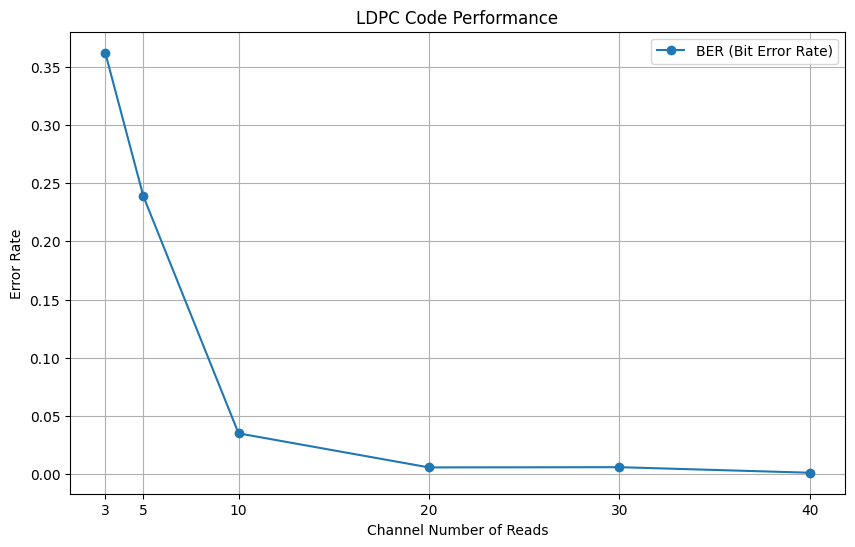

In [40]:
# Plot the results (BER)
plt.figure(figsize=(10, 6))
plt.plot(results['nb_reads'], results['ber'], 'o-', label='BER (Bit Error Rate)')
plt.xlabel('Channel Number of Reads')
plt.xticks(results['nb_reads'])
plt.ylabel('Error Rate')
plt.legend()
plt.title('LDPC Code Performance')
plt.grid(True)
plt.show()

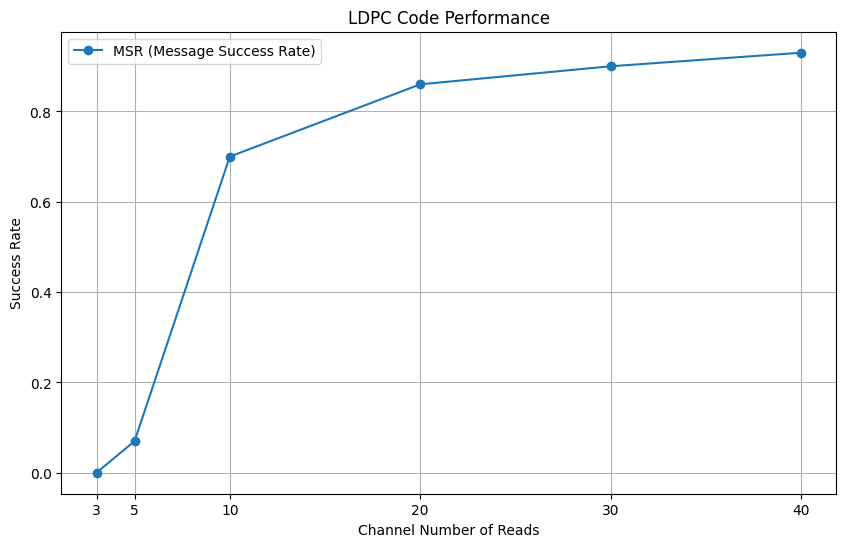

In [41]:
# Plot the results (MSR)
plt.figure(figsize=(10, 6))
plt.plot(results['nb_reads'], results['MSR'], 'o-', label='MSR (Message Success Rate)')
plt.xlabel('Channel Number of Reads')
plt.xticks(results['nb_reads'])
plt.ylabel('Success Rate')
plt.legend()
plt.title('LDPC Code Performance')
plt.grid(True)
plt.show()

In [54]:
# Last performance evaluation
print("Final performance evaluation:")
print("MSR result for 3 reads :", results['MSR'][0])
print("BER result for 3 reads :", results['ber'][0])
print("MSR result for 5 reads :", results['MSR'][1])
print("BER result for 5 reads :", results['ber'][1])
print("MSR result for 10 reads :", results['MSR'][2])
print("BER result for 10 reads :", results['ber'][2])
print("MSR result for 20 reads :", results['MSR'][3])
print("BER result for 20 reads :", results['ber'][3])
print("MSR result for 30 reads :", results['MSR'][4])
print("BER result for 30 reads :", results['ber'][4])
print("MSR result for 40 reads :", results['MSR'][5])
print("BER result for 40 reads :", results['ber'][5])

Final performance evaluation:
MSR result for 3 reads : 0.0
BER result for 3 reads : 0.36206
MSR result for 5 reads : 0.07
BER result for 5 reads : 0.23882
MSR result for 10 reads : 0.7
BER result for 10 reads : 0.03508
MSR result for 20 reads : 0.86
BER result for 20 reads : 0.00582
MSR result for 30 reads : 0.9
BER result for 30 reads : 0.00602
MSR result for 40 reads : 0.93
BER result for 40 reads : 0.00126


## Tests sur image IMT

In [135]:
# Definition of the DNA sequence
IMTXdna = imageToDna("IMT.png")

# Create binary file
imageToBinary("IMT.png")

# Load the file IMT_binary.
IMT_binary = ""
with open("IMTbinary_.txt", "r") as f:
    IMT_binary = f.read().strip()
os.remove("IMTbinary_.txt")

In [43]:
# Create a list that divides the DNA sequence into N parts
IMTXdna = [IMTXdna[i:i+N] for i in range(0, len(IMTXdna), N)]

In [44]:
# Create two LDPC codes for each type of sequence
ldpc1 = LDPC(k=len(DnaToBinary(IMTXdna[0])), rate=0.7)
ldpc2 = LDPC(k=len(DnaToBinary(IMTXdna[len(IMTXdna) - 1])), rate=0.7)

In [45]:
# Apply the channel to each fragment
decoded_fragments = []

for fragment in IMTXdna:
    if len(fragment) != N:
        ldpc = ldpc2
    else:
        ldpc = ldpc1
    
    # Convert the fragment to a binary sequence
    binary_fragment = DnaToBinary(fragment)

    # Encode the fragment
    codeword_fragment = ldpc.encode(binary_fragment)

    # Convert the codeword to a DNA sequence
    Xdna_fragment = binaryToDna(codeword_fragment)

    # Delete homopolymers
    Xdna_fragment = insert_nucleotide_in_homopolymers(''.join(Xdna_fragment), 6)

    # Apply the simulated channel
    reads_fragment = use_model(Xdna_fragment, Nb_reads)

    # Build the consensus sequence
    to_fasta(reads_fragment, "fastaSequences/reads_fragment.fasta")
    aligned_sequences_fragment = align_sequences("fastaSequences/reads_fragment.fasta")
    consensus_fragment = build_consensus(aligned_sequences_fragment)

    # Insert primers
    consensus_fragment = insert_primers(consensus_fragment, [Xdna_fragment[:N_primer], Xdna_fragment[-N_primer:]], N_primer)

    # Synchronize the sequence
    synchro_consensus_fragment = synchronize_sequences(ldpc, consensus_fragment, len(codeword_fragment))

    # Received message
    received_fragment = DnaToBinary(synchro_consensus_fragment)

    # Only keep the first n bits
    received_fragment = received_fragment[:ldpc.n]
    
    # Pad with zeros if necessary
    if len(received_fragment) < ldpc.n:
        padding = np.zeros(ldpc.n - len(received_fragment), dtype=np.int8)
        received_fragment = np.concatenate((received_fragment, padding))
    
    # Decode the received codeword
    decoded_fragment = ldpc.decode(received_fragment)

    # Add to the list of decoded fragments
    decoded_fragments.append(decoded_fragment)

In [130]:
# Concatenate the decoded fragments into a single binary sequence
decoded_image = np.concatenate(decoded_fragments)

# Convert the binary sequence back to a DNA sequence
decoded_dna = binaryToDna(decoded_image)

# Concat IMTXdna - handling both list and string fragments
IMTXdna_decoded = ''
for fragment in IMTXdna:
	if isinstance(fragment, list):
		IMTXdna_decoded += ''.join(fragment)
	else:
		IMTXdna_decoded += fragment

# Count number of errors in the decoded message
num_errors = np.sum(np.array(list(IMTXdna_decoded)) != np.array(list(decoded_dna)))
print(f"Number of bit errors in decoded image: {num_errors} out of {len(decoded_image)} bits ({num_errors/len(decoded_image):.2%})")

Number of bit errors in decoded image: 9356 out of 281840 bits (3.32%)


In [136]:
len(decoded_dna), len(IMTXdna_decoded)

(140920, 140920)

In [189]:
# Convert back the image from DNA to image
dnaToImage(IMTXdna_decoded, "IMT_goal.png")

Number of characters: 2


'IMT_goal.png'

In [194]:
# Convert back to image
dnaToImage(decoded_dna, "IMT_decoded.png")

ValueError: invalid literal for int() with base 10: 'þ\x87\x86\x7fkð/\x83\x7fI\x06ÿ&\x00$\x19ü«ëßq,m\x12@\x06ÿ2ø\x97$\x83\x7f\x13\x00\x92Á¿L\x02H\x06ÿ2ø\x97dð/\x13\x00\x92Á¿L\x02Èà_2ø\x97dðo\x02@\x92Á¿L\x02Èà_2ø\x97dðo\x02@\x92Á¿L\x02Èà_\x06ÿ\x92dðo\x0